In [1]:
import json
import sqlite3
import numpy as np
from typing import List

from gameSimulation.jsonDeEncoders import decodingHooks

from itertools import groupby

from datetime import datetime

from scipy import stats

# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import matplotlib.ticker as mplTicker
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

mplstyle.use('fast')
mplstyle.use('default')
# mpl.rcParams['figure.figsize'] = [20, 10]

colors = ["green", "blue", "red","orange","purple","gold"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)


db_file_name="G:/Uni/BA/data/gameHistories_scoreDR.db"

In [2]:
delta0 = datetime.now()
con = sqlite3.connect(db_file_name)
con.row_factory = lambda _, row: list(row)
rows_raw = con.execute( '''select gameSettingsID,roundcount,stepcount,winners from game''' ).fetchall()
con.close()
delta1 = datetime.now()
print("db load finished after {}".format( delta1-delta0))
rows_raw.sort(key=lambda r: r[0])
delta2 = datetime.now()
print("sort finished after {}".format( delta2-delta1))

rows =  [list(g) for _, g in groupby(rows_raw, lambda r: r[0])]
delta3 = datetime.now()
print("groupby finished after {}".format( delta3-delta2))
rows.sort(key=lambda rows_sub: np.median([r for _,r,_,_ in rows_sub]))
delta3_1 = datetime.now()
print("sort finished after {}".format( delta3_1-delta1))

settings_all =  [[s for s,_,_,_ in rows_sub] for rows_sub in rows]
settings = [min(sub) if min(sub) == max(sub) else -1 for sub in settings_all]
roundCounts =  [[r for _,r,_,_ in rows_sub] for rows_sub in rows]
stepCounts =  [[s for _,_,s,_ in rows_sub] for rows_sub in rows]
winners =  [[w for _,_,_,w in rows_sub] for rows_sub in rows]
delta4 = datetime.now()
print("split finished after {}".format( delta4-delta3_1))




# stepCounts = [con.execute(
#     '''select stepcount from game where gameSettingsID == (?)''',
#     i).fetchall() for i in distinctSettings]
# winners = [[json.loads(r) for r in con.execute(
#     '''select winners from game where gameSettingsID == (?)''',
#     i).fetchall()] for i in distinctSettings]


len(winners)
settings

db load finished after 0:00:29.011522
sort finished after 0:00:00.416093
groupby finished after 0:00:00.482109
sort finished after 0:00:01.740393
split finished after 0:00:01.634366


[4, 1, 3, 5, 0, 2]

In [3]:
len(rows)
tmp = [np.median([r for _,r,_,_ in rows_sub]) for rows_sub in rows]
tmp[0]

45.0

In [4]:
con = sqlite3.connect(db_file_name)
con.row_factory = lambda _, row: list(row)
labels = [(r[0]," vs ".join([p.getStrategy().getName() for p in  json.loads(r[1],object_hook=decodingHooks)])) for r in con.execute('''select gameSettingsID,players from gameSettings''', ).fetchall()]

con.close()
labels.sort(key=lambda x: settings.index(x[0]))
labels = [name for _,name in labels]
labels

['Score_DR vs Score_DR',
 'Score_DR vs MoveFirst',
 'Score_DR vs Score_DR+MD',
 'Score_DR vs Score_TO',
 'Score_DR vs random',
 'Score_DR vs MoveLast']

In [5]:
# roundCounts = roundCounts[:4]
# stepCounts = stepCounts[:4]
# labels = labels[:4]
[ sum(rc)/len(rc) if len(rc) else -1 for rc in roundCounts[:4]]



[45.680629333333336, 46.2115975, 46.695968, 46.44664266666667]

In [14]:
[(len(dt),labels[i]) for i,dt in enumerate(roundCounts)]


[(750000, 'Score_DR vs Score_DR'),
 (800000, 'Score_DR vs MoveFirst'),
 (750000, 'Score_DR vs Score_DR+MD'),
 (750000, 'Score_DR vs Score_TO'),
 (1950000, 'Score_DR vs random'),
 (750000, 'Score_DR vs MoveLast')]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


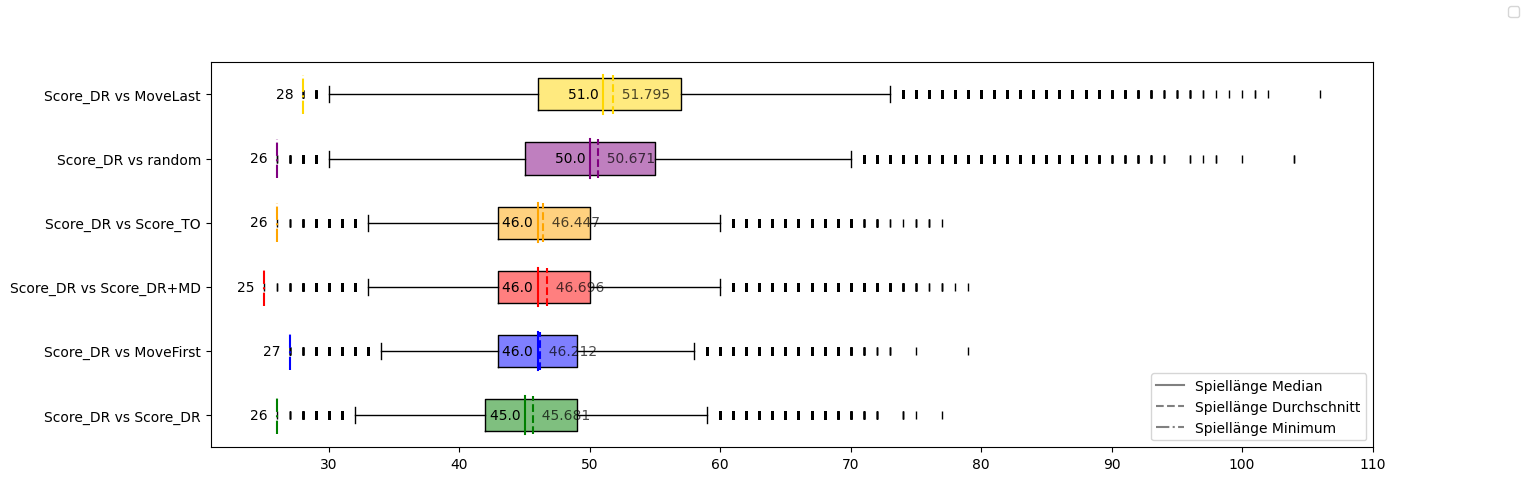

In [7]:
def makeVlines(ax:axes.Axes,x:List[np.float64],yVlaues:List[List[np.float64]],ls:str, alpha=1.0):
    if len(yVlaues)>0:
        for i,a in enumerate(x):
            offset = 1/((len(x))*5)
            ax.axvline(a, color=colors[i],ymin=offset*(i*5+1),ymax=offset*(i*5+4),  ls=ls, alpha=alpha)
    else:
        for i,a in enumerate(x):
            ax.axvline(a, color=colors[i],  ls=ls, alpha=alpha)

def colorboxplot(data:List, ax:axes.Axes,labels:List[str])->List[np.float64]:
    medianprops = dict(linestyle='-.', linewidth=0, color='firebrick')
    bp = ax.boxplot(data, 0, "|", False, labels=labels,medianprops=medianprops,autorange=True)
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    minimums = np.empty(num_boxes)
    yValues = np.empty((num_boxes,2))

    for i in range(num_boxes):
        box = bp['boxes'][i]

        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax.add_patch(mpatches.Polygon(box_coords, facecolor=colors[i], alpha=.5))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        minimum = min(data[i])
        

        minimums[i] = minimum
        medians[i] = med.get_xdata()[0]
        yValues[i] = med.get_ydata()

        ax.text( med.get_xdata()[0], i+1, "{} ".format(med.get_xdata()[0]),
         horizontalalignment='right', verticalalignment="center")

        ax.text( minimum, i+1, "{}  ".format(minimum),
         horizontalalignment='right', verticalalignment="center")

        ax.text( np.average(data[i]), i+1, "  {:0.3f}".format(np.average(data[i])),
         horizontalalignment='left', verticalalignment="center", alpha=.7)

        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        # ax.plot( np.average(data[i]),i+1,
        #         color='w', marker='|', markersize=12,markeredgecolor='k')
    makeVlines(ax,medians,yValues,"-")
    makeVlines(ax,minimums,yValues,"-.")
    makeVlines(ax,[np.average(data_) for data_ in data],yValues,"--")

    median_legend = mpl.lines.Line2D([], [], ls="-", color='grey',
                          label='Spiellänge Median')
    avg_legend = mpl.lines.Line2D([], [], ls="--", color='grey',
                          label='Spiellänge Durchschnitt')
    fliers_legend = mpl.lines.Line2D([], [], ls="-.", color='grey',
                          label='Spiellänge Minimum')

    ax.legend(handles=[median_legend,avg_legend,fliers_legend])


fig, ax = plt.subplot_mosaic([["Boxplots Runden"]], figsize=[15, 5])
colorboxplot(roundCounts,ax["Boxplots Runden"],labels)
fig.legend()

3.5
0.020000000000000004


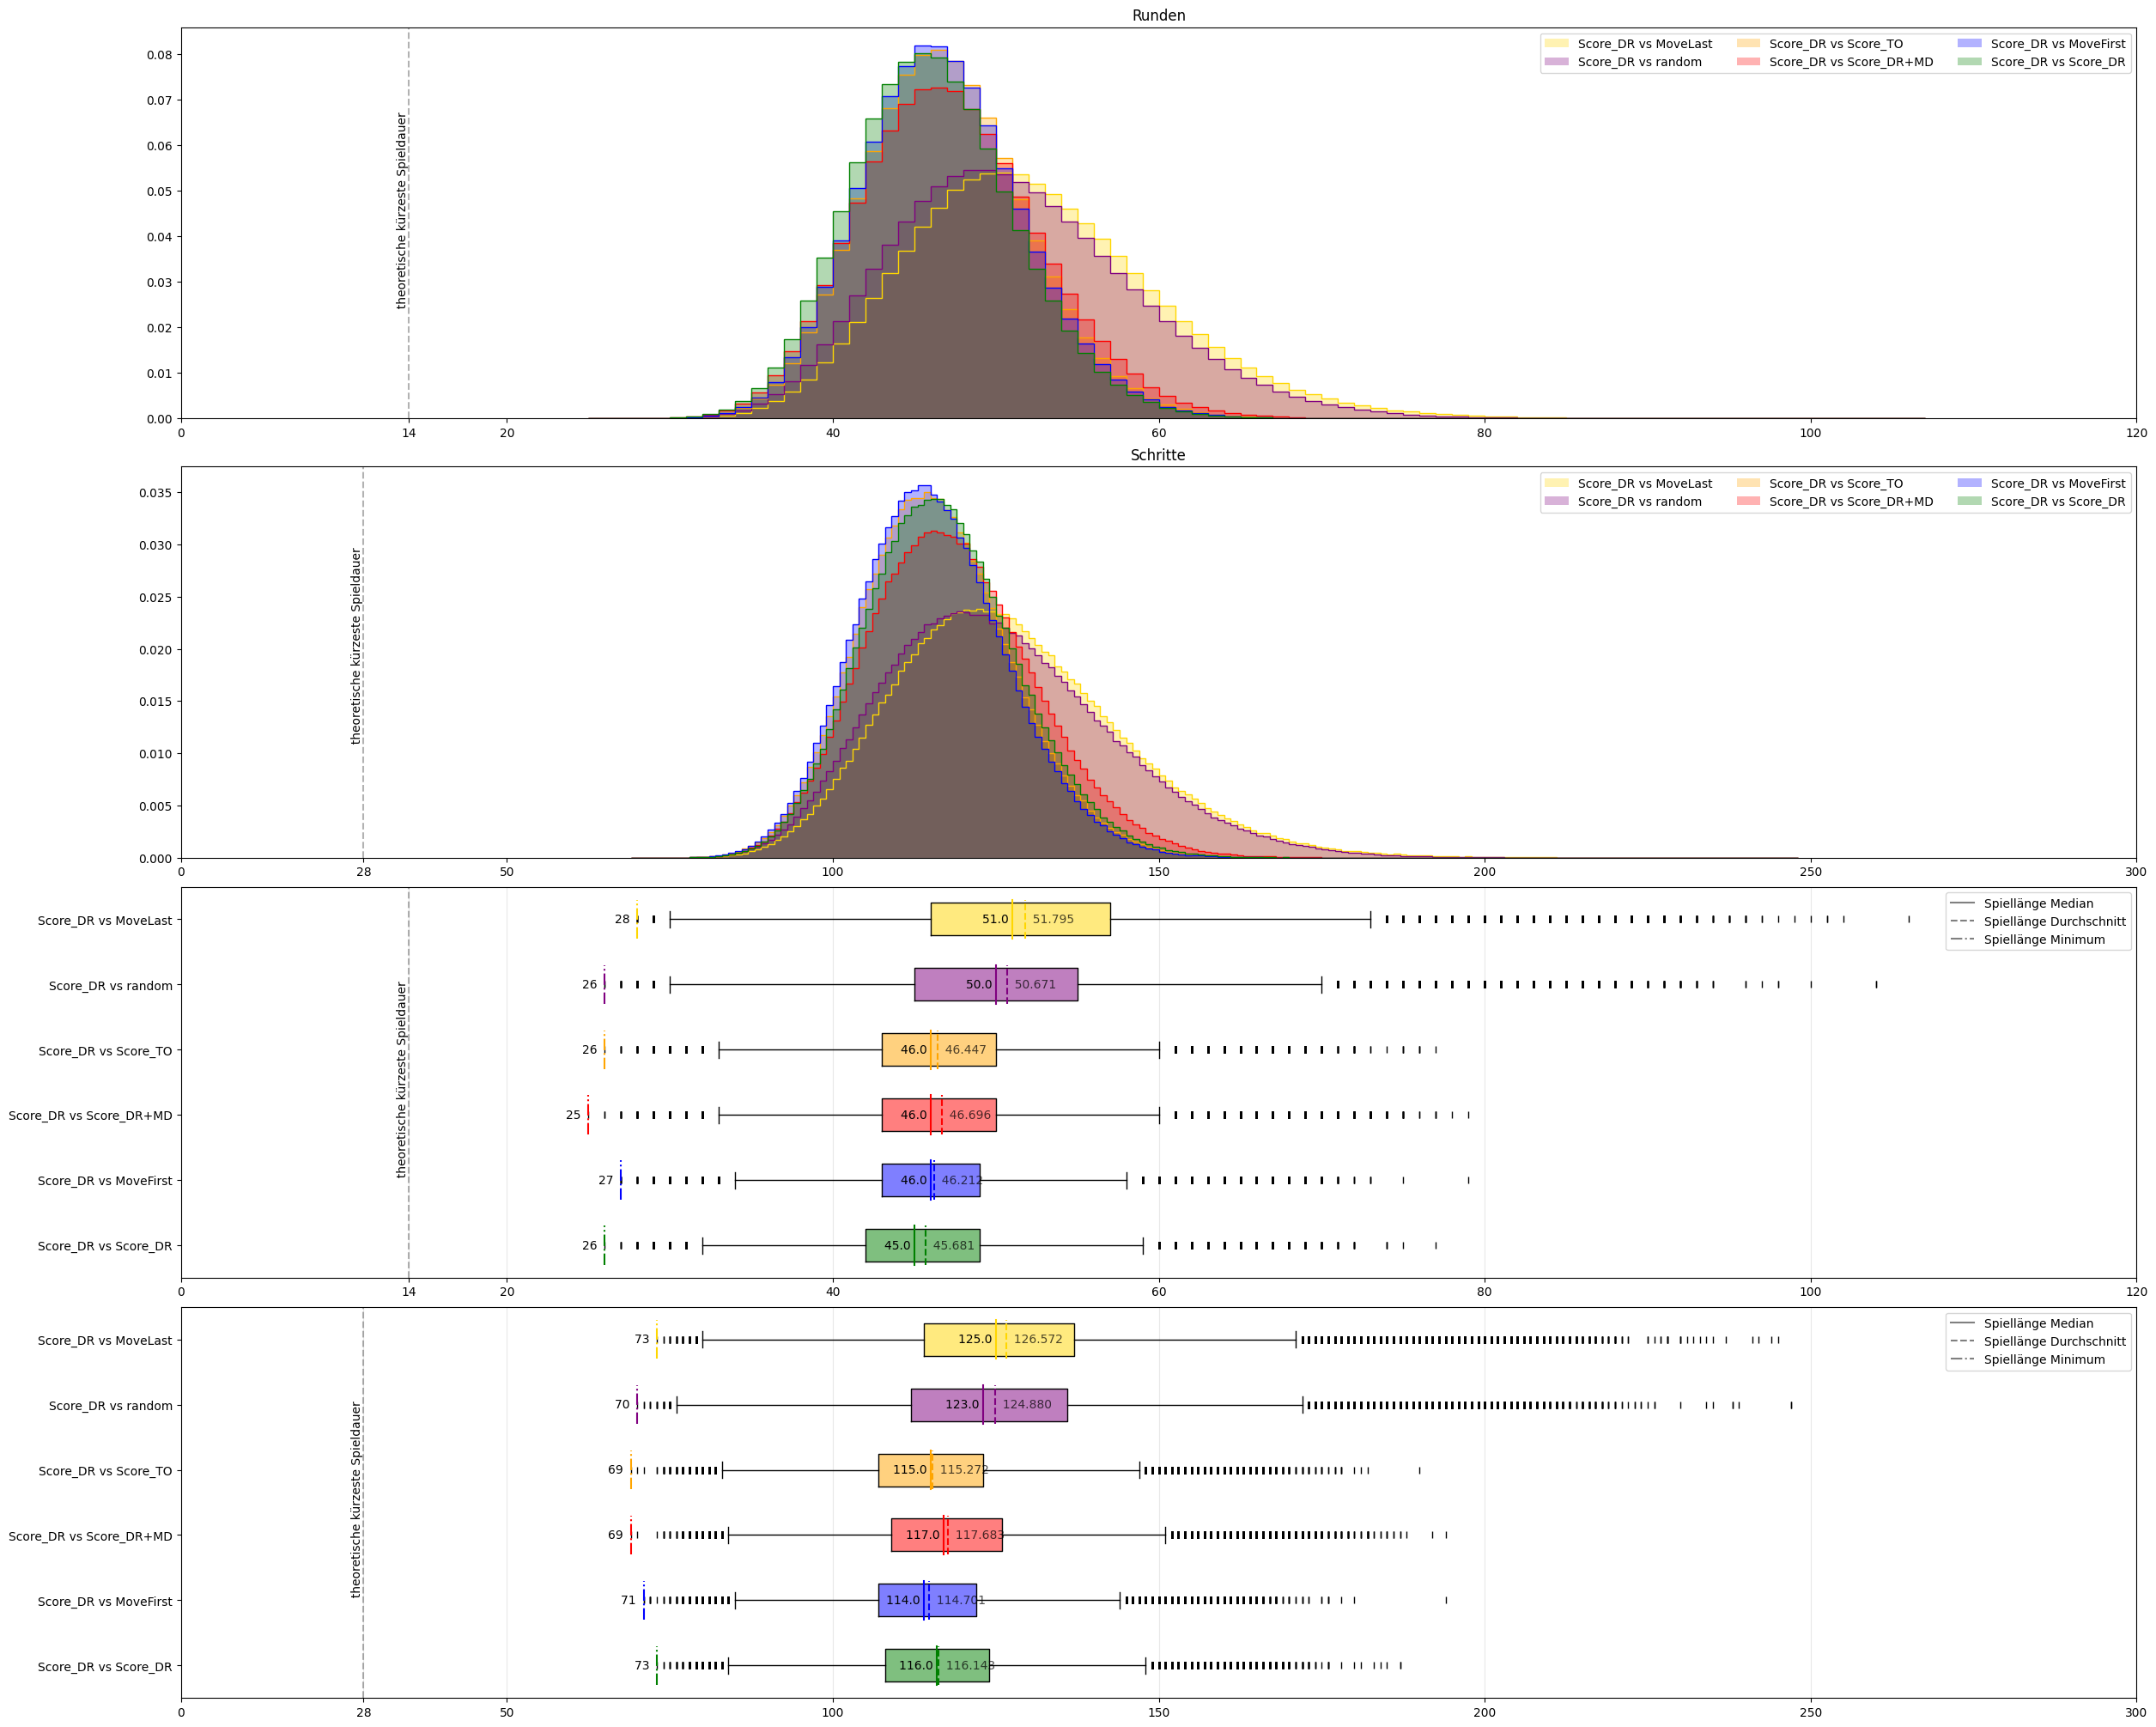

In [8]:
def makeGraph(roundCounts,stepCounts, labels):

    fig, ax = plt.subplot_mosaic([["Runden"], ["Schritte"],["Boxplots Runden"],["Boxplots Schritte"]], figsize=[25, 20],layout="constrained")

    # for i,gl_stacked_ in enumerate(gl_stacked):
    #         ax.bar([x for x, _ in gl_stacked_], [
    #                 y for _, y in gl_stacked_], alpha=0.5, label=xlabels[i])
    #         # ax.plot(gl[i], alpha=0.5)
    ax["Runden"].set_title("Runden")
    maxBin=max([max(x) for x in roundCounts])
    minBin=min([min(x) for x in roundCounts])
    bins = range(minBin, maxBin+2)
    hst = ax["Runden"].hist(roundCounts, color=colors[:len(roundCounts)], density=True, histtype="step",
            bins=bins)
    ax["Runden"].hist(roundCounts, color=colors[:len(roundCounts)], label=labels, density=True, histtype="stepfilled",
            alpha=.3, bins=bins)
    # ax["Runden"].boxplot(roundCounts, 0, ".", False, labels=labels,whis=1)

    ax["Schritte"].set_title("Schritte")
    maxBin=max([max(x) for x in stepCounts])
    minBin=min([min(x) for x in stepCounts])
    bins = range(minBin, maxBin+2)
    ax["Schritte"].hist(stepCounts, color=colors[:len(stepCounts)], density=True,  histtype="step",
            bins=bins)
    ax["Schritte"].hist(stepCounts, color=colors[:len(stepCounts)], label=labels, density=True, histtype="stepfilled",
            alpha=.3, bins=bins)

    roundMedians = colorboxplot(roundCounts,ax["Boxplots Runden"],labels)
    stepMedians = colorboxplot(stepCounts,ax["Boxplots Schritte"],labels)
    ax["Boxplots Runden"].xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax["Boxplots Schritte"].xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    
    for ax_ in [ax["Boxplots Runden"],ax["Runden"]]:
        ax_.axvline(14, color=(0, 0, 0, 0.3),  ls='--')
        ax_.set_xticks(list(ax_.get_xticks())+[14])
        ax_.text(14,np.mean(list(ax_.get_yticks())),"  theoretische kürzeste Spieldauer",rotation=90,ha="right",va="center")
    for ax_ in [ax["Boxplots Schritte"],ax["Schritte"]]:
        ax_.axvline(28, color=(0, 0, 0, 0.3),  ls='--')
        ax_.set_xticks(list(ax_.get_xticks())+[28])
        print(np.mean(list(ax_.get_yticks())))
        ax_.text(28,np.mean(list(ax_.get_yticks())),"  theoretische kürzeste Spieldauer",rotation=90,ha="right",va="center")




    for name in ax:
        if name not in ["Boxplots Runden","Boxplots Schritte"]:
            ax[name].legend(ncol=3)

a0,a1=(0,5)
# makeGraph(roundCounts[a0:a1],stepCounts[a0:a1], labels[a0:a1])
makeGraph(roundCounts,stepCounts, labels)

In [9]:
# con = sqlite3.connect("G:/Uni/BA/data/gameHistoriesDice.db")
# con.row_factory = lambda _, row: list(row)
# rows_raw = con.execute( '''select diceroll from game''' ).fetchall()
# # rows_raw.sort(key=lambda r: r[1])
# # rows =  [list(g) for _, g in groupby(rows_raw, lambda r: r[3])]
# dicethrows_raw = [[item for sublist in [json.loads(dr[0]) for dr in rows ]for item in sublist]]

# con.close()


In [10]:
# dicethrows = dicethrows_raw 
# [[dt.count(x) for x in range(0,5)]  for dt in dicethrows]
# (sum([len(dt) for dt in winners]),sum([len(dt) for dt in dicethrows]))

In [11]:
# fig, ax = plt.subplot_mosaic([labels], figsize=[15, 10])
# for i, label in enumerate(labels):
#     ax[label].set_title(label)
#     bins = range(0, max(dicethrows[i])+2)
#     ax[label].hist(dicethrows[i], color=colors[i],
#                    density=True,  histtype="step", align="left", bins=bins)
#     ax[label].hist(dicethrows[i], color=colors[i], label=labels,
#                    density=True, histtype="stepfilled", align="left", alpha=.3, bins=bins)



[51.16853333333333, 58.468125, 69.92293333333333, 57.384, 96.72138461538462, 99.99173333333333]
[48.83146666666667, 41.531875, 30.077066666666667, 42.616, 3.2786153846153847, 0.008266666666666667]


C:\Users\walli\AppData\Local\Temp/ipykernel_10176/143708403.py:39: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


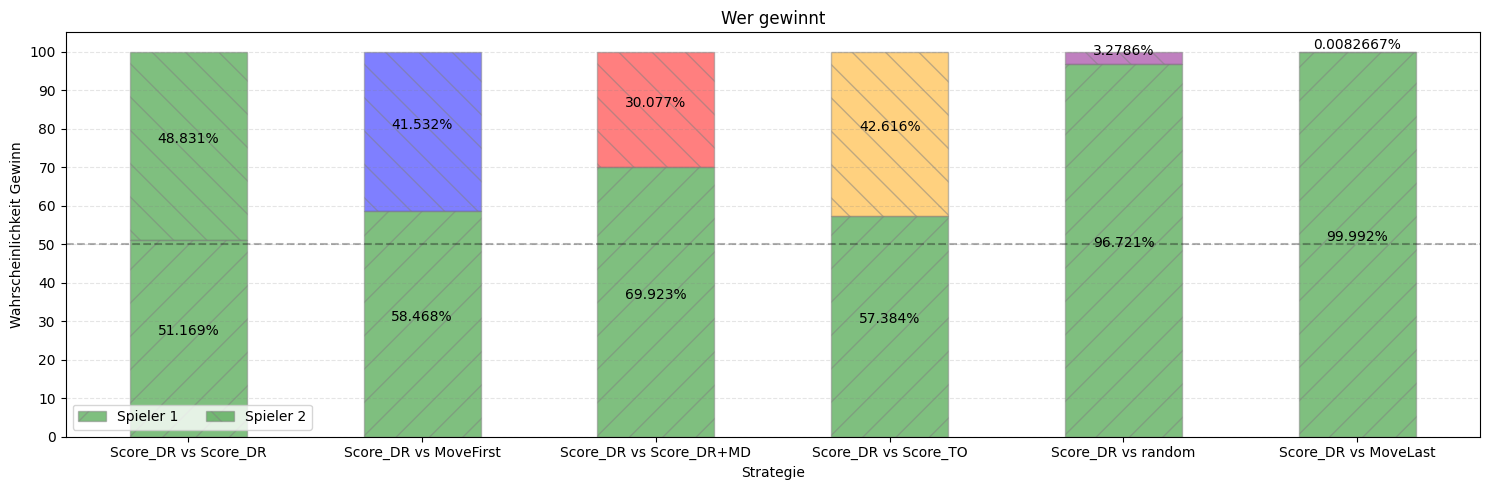

In [16]:
# xlabels = ['No Influence', 'fight', 'fight incl. double']
# xlabels = ["MultiD2Dice(4)",
# "MultiD2Dice(3)",
# "MultiD2DiceNo0(3)",
# "D4()"]
# xlabels=["MF vs MF","S vs MF","S vs S"]
# player0 = [s.count(["p0"]) for s in winners]
# player1 = [s.count(["p1"]) for s in winners]
player0 = [s.count('["p0"]')/len(s)*100 for s in winners]
player1 = [s.count('["p1"]')/len(s)*100 for s in winners]
no_one = [s.count("[]")/len(s)*100 for s in winners]
both = [s.count(["p0", "p1"])/len(s)*100 for s in winners]
print(player0)
print(player1)

fig, ax = plt.subplots(figsize=[15,5], layout="constrained")
# hat_graph(ax, xlabels, [player0, player1], ['Player 0', 'Player 1'])

p0 = ax.bar(labels,player0,label="Spieler 1", alpha=.5,width=.5, color=colors[0], hatch='/',edgecolor='gray')
p1 = ax.bar(labels,player1,label="Spieler 2", alpha=.5,width=.5,bottom=player0,color=colors, hatch='\\',edgecolor='gray')
# ab = ax.bar(labels,no_one,label="Abbruch", alpha=.8,width=.5,bottom=[sum(x) for x in zip(player0, player1)])
# ev = ax.bar(labels, both, label="Unentschieden", alpha=.8, width=.5,bottom=[sum(x) for x in zip(player0, player1,no_one)])

ax.bar_label(p0, label_type='center',fmt="%3.5g%%", padding=5)
ax.bar_label(p1, label_type='center',fmt="%3.5g%%", padding=5)
# ax.bar_label(ab, label_type='center',fmt="%3.5g%%", padding=5)
# ax.bar_label(ev, label_type='center',fmt="%3.5g%%", padding=5)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Strategie')
ax.set_ylabel('Wahrscheinlichkeit Gewinn')
ax.set_title('Wer gewinnt')
# ax.legend( loc='lower center', ncol=2)
ax.legend( loc='lower left',
                      ncol=2)
ax.axhline(50, color=(0, 0, 0, 0.3),  ls='--')

fig.tight_layout()
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis="y",color=("gray"),alpha = .2,ls="--")
plt.show()


In [13]:
[*[10]*10]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]